# Emergency Room Patient Volume Prediction

This project aims to predict emergency room patient volume 4 hours in advance using machine learning techniques.

**Target Metrics:**
- MAPE < 20%
- MAE < 3 patients
- R² > 0.70

## Table of Contents
1. Data Loading and Preparation
2. Exploratory Data Analysis (EDA)
3. Feature Engineering
4. Model Training
5. Performance Evaluation
6. Predictions Visualization

In [87]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('husl')

## 1. Data Loading and Preparation

In [88]:
# Load training data (based on realistic patterns from research)
data_path = 'real_data/processed/er_prediction_realistic_data.csv'
if not os.path.exists(data_path):
    raise FileNotFoundError(
        f"Eğitim verisi bulunamadı: {data_path}\n"
        f"Lütfen önce 'python generate_training_data.py' komutunu çalıştırarak veriyi oluşturun."
    )

print(f"📥 Eğitim verisi yükleniyor: {data_path}")
df = pd.read_csv(data_path)

# Ensure datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# Sort by datetime and reset index
df = df.sort_values('datetime').reset_index(drop=True)

print(f"✅ Veri yüklendi: {len(df)} kayıt, {len(df.columns)} sütun")
print(f"📅 Tarih aralığı: {df['datetime'].min()} - {df['datetime'].max()}")
print(f"🏥 Hasta sayısı (min/ort/max): {df['patient_count'].min()} / {df['patient_count'].mean():.1f} / {df['patient_count'].max()}")
print(f"📊 Not: Bu veri eğitim amaçlı oluşturulmuştur. Üretim için gerçek hastane verisi kullanılmalıdır.")

df.head()

📥 Eğitim verisi yükleniyor: real_data/processed/er_prediction_realistic_data.csv
✅ Veri yüklendi: 17521 kayıt, 17 sütun
📅 Tarih aralığı: 2022-01-01 00:00:00 - 2024-01-01 00:00:00
🏥 Hasta sayısı (min/ort/max): 4 / 39.9 / 126
📊 Not: Bu veri eğitim amaçlı oluşturulmuştur. Üretim için gerçek hastane verisi kullanılmalıdır.


,datetime,hour,day_of_week,month,day_of_year,is_weekend,patient_count,temperature,humidity,pressure,precipitation,wind_speed,visibility,is_raining,rainfall_mm,is_holiday,day_type
0,2022-01-01 00:00:00,0,5,1,1,1,38,-2.474804,98.494951,1016.687975,0.000000,0.380689,9.889321,0,0.000000,1,holiday
1,2022-01-01 01:00:00,1,5,1,1,1,20,-4.550991,100.000000,997.908215,0.000000,3.387830,8.485242,0,0.000000,1,holiday
2,2022-01-01 02:00:00,2,5,1,1,1,24,-9.469731,100.000000,1011.676911,0.000000,3.344574,8.157465,0,0.000000,1,holiday
3,2022-01-01 03:00:00,3,5,1,1,1,14,-5.413537,100.000000,1014.958929,0.932217,0.976195,7.409592,1,0.932217,1,holiday
4,2022-01-01 04:00:00,4,5,1,1,1,15,0.376643,100.000000,1018.327575,0.640834,4.433822,5.689371,1,0.640834,1,holiday


In [89]:
# Basic data info
print("Dataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17521 entries, 0 to 17520
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       17521 non-null  datetime64[ns]
 1   hour           17521 non-null  int64         
 2   day_of_week    17521 non-null  int64         
 3   month          17521 non-null  int64         
 4   day_of_year    17521 non-null  int64         
 5   is_weekend     17521 non-null  int64         
 6   patient_count  17521 non-null  int64         
 7   temperature    17521 non-null  float64       
 8   humidity       17521 non-null  float64       
 9   pressure       17521 non-null  float64       
 10  precipitation  17521 non-null  float64       
 11  wind_speed     17521 non-null  float64       
 12  visibility     17521 non-null  float64       
 13  is_raining     17521 non-null  int64         
 14  rainfall_mm    17521 non-null  float64       
 15  is_ho

## 2. Exploratory Data Analysis (EDA)

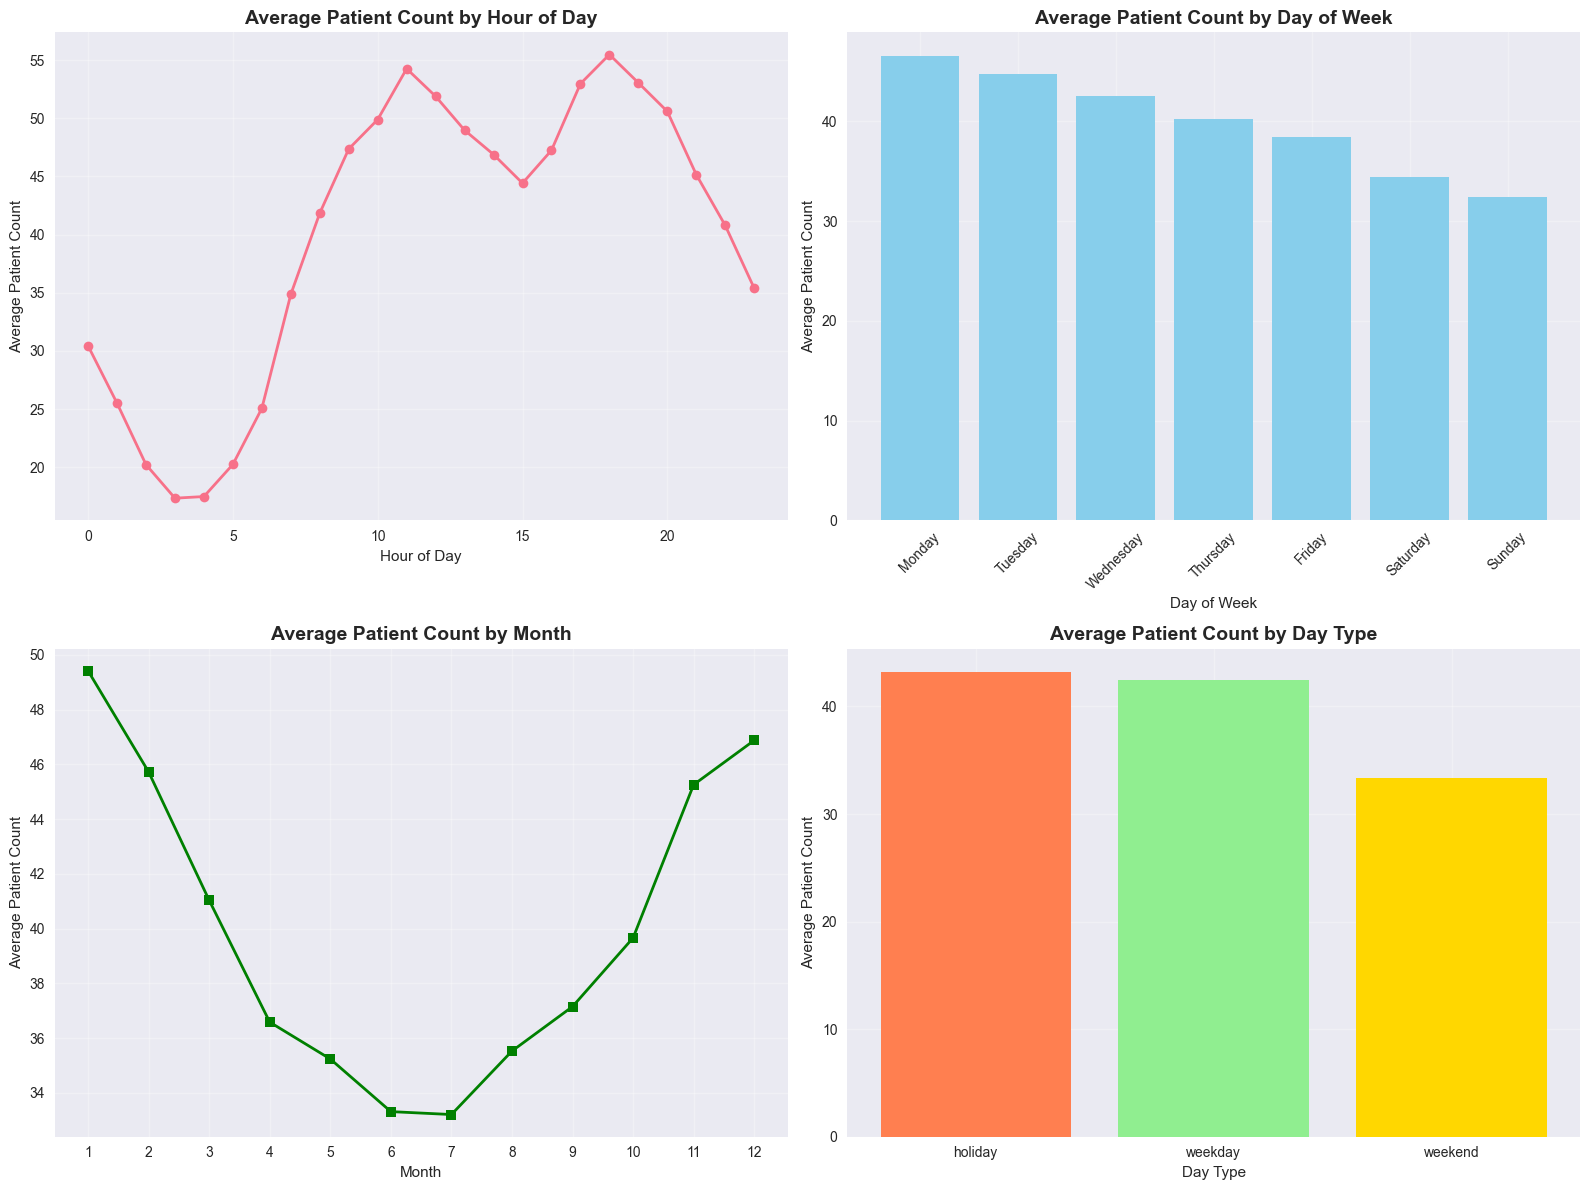

In [90]:
# Hourly patient trends
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Hourly patterns
hourly_avg = df.groupby('hour')['patient_count'].mean()
axes[0, 0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
axes[0, 0].set_title('Average Patient Count by Hour of Day', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Average Patient Count')
axes[0, 0].grid(True, alpha=0.3)

# Day of week patterns
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_avg = df.groupby('day_of_week')['patient_count'].mean()
axes[0, 1].bar(range(7), dow_avg.values, color='skyblue')
axes[0, 1].set_title('Average Patient Count by Day of Week', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Average Patient Count')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(dow_names, rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Monthly patterns
monthly_avg = df.groupby('month')['patient_count'].mean()
axes[1, 0].plot(monthly_avg.index, monthly_avg.values, marker='s', linewidth=2, color='green')
axes[1, 0].set_title('Average Patient Count by Month', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Patient Count')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].grid(True, alpha=0.3)

# Day type comparison
daytype_avg = df.groupby('day_type')['patient_count'].mean()
axes[1, 1].bar(daytype_avg.index, daytype_avg.values, color=['coral', 'lightgreen', 'gold'])
axes[1, 1].set_title('Average Patient Count by Day Type', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Day Type')
axes[1, 1].set_ylabel('Average Patient Count')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

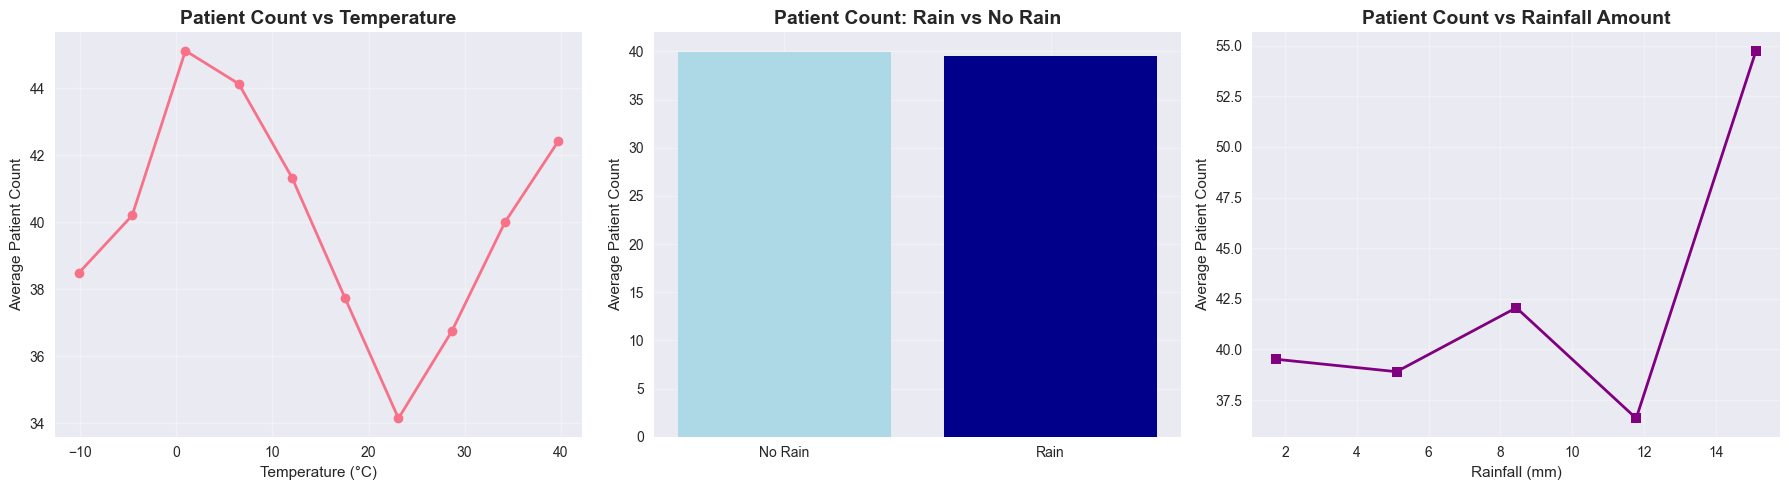

In [91]:
# Weather impact analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Temperature vs patient count
temp_bins = pd.cut(df['temperature'], bins=10)
temp_avg = df.groupby(temp_bins)['patient_count'].mean()
temp_centers = [interval.mid for interval in temp_avg.index]
axes[0].plot(temp_centers, temp_avg.values, marker='o', linewidth=2)
axes[0].set_title('Patient Count vs Temperature', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Temperature (°C)')
axes[0].set_ylabel('Average Patient Count')
axes[0].grid(True, alpha=0.3)

# Rain impact
rain_impact = df.groupby('is_raining')['patient_count'].mean()
axes[1].bar(['No Rain', 'Rain'], rain_impact.values, color=['lightblue', 'darkblue'])
axes[1].set_title('Patient Count: Rain vs No Rain', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Average Patient Count')
axes[1].grid(True, alpha=0.3)

# Rainfall amount impact (when raining)
rainy_data = df[df['is_raining'] == 1]
if len(rainy_data) > 0:
    rainfall_bins = pd.cut(rainy_data['rainfall_mm'], bins=5)
    rainfall_avg = rainy_data.groupby(rainfall_bins)['patient_count'].mean()
    rainfall_centers = [interval.mid for interval in rainfall_avg.index]
    axes[2].plot(rainfall_centers, rainfall_avg.values, marker='s', linewidth=2, color='purple')
    axes[2].set_title('Patient Count vs Rainfall Amount', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Rainfall (mm)')
    axes[2].set_ylabel('Average Patient Count')
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

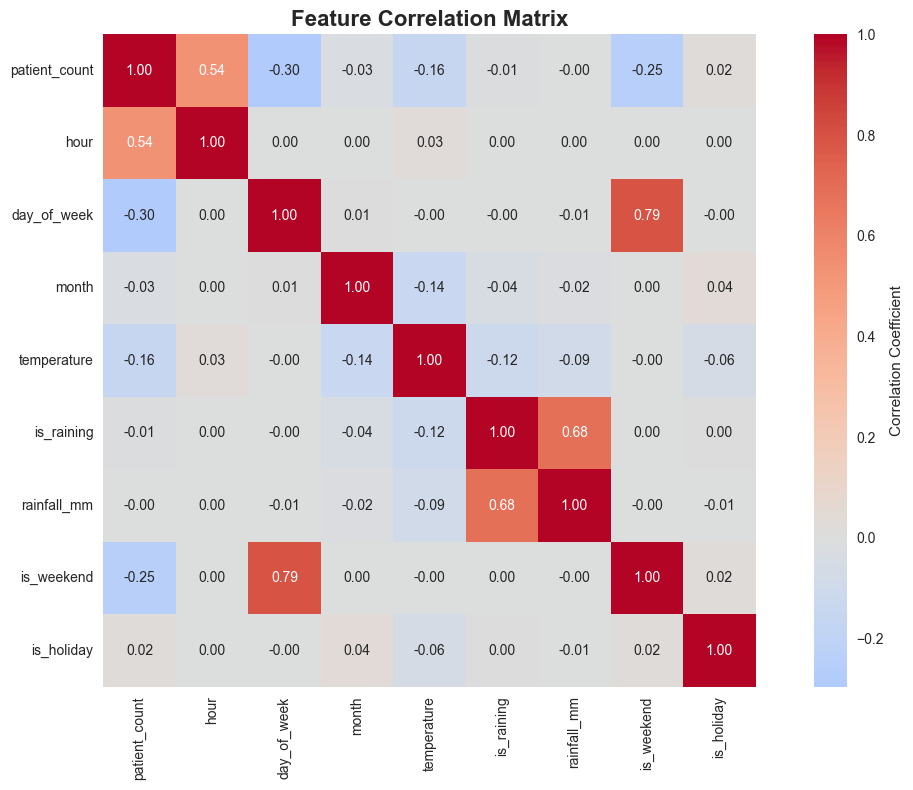

In [92]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_cols = ['patient_count', 'hour', 'day_of_week', 'month', 'temperature', 
                   'is_raining', 'rainfall_mm', 'is_weekend', 'is_holiday']
correlation_matrix = df[correlation_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

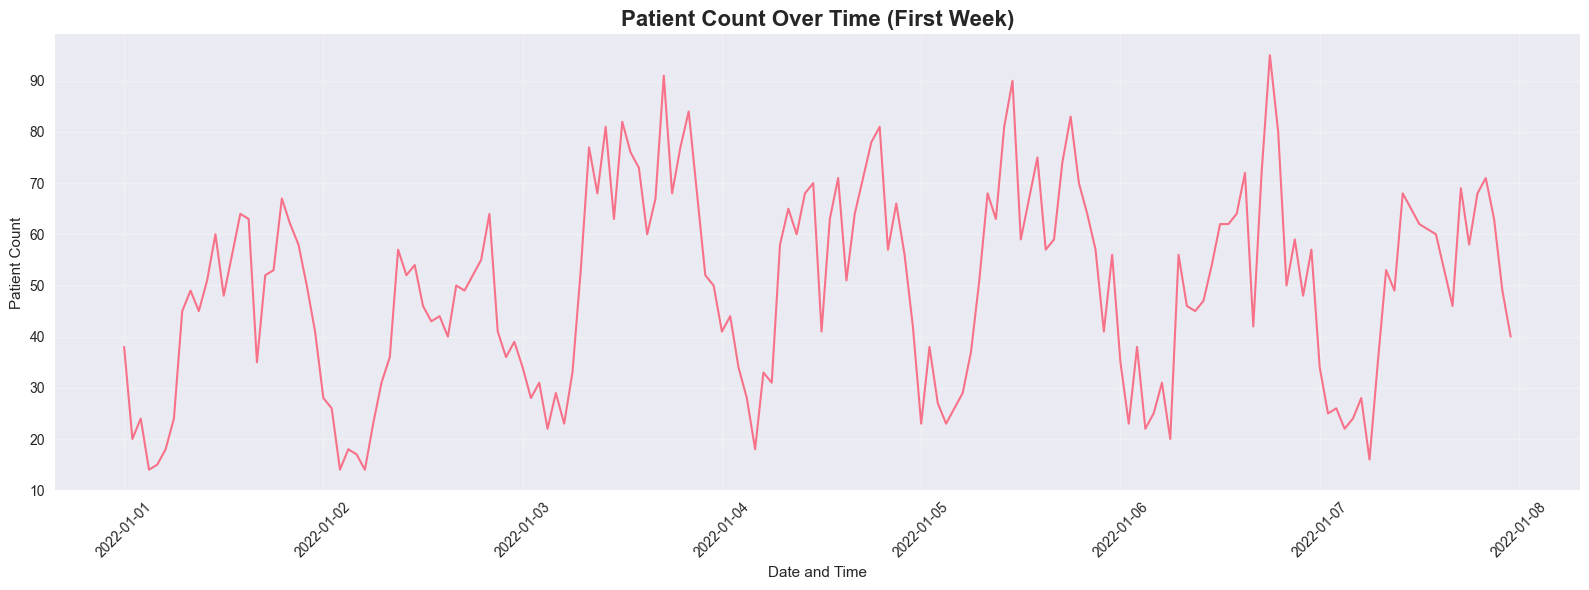

In [93]:
# Time series plot
plt.figure(figsize=(16, 6))
sample_data = df.iloc[:24*7]  # First week
plt.plot(sample_data['datetime'], sample_data['patient_count'], linewidth=1.5)
plt.title('Patient Count Over Time (First Week)', fontsize=16, fontweight='bold')
plt.xlabel('Date and Time')
plt.ylabel('Patient Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [94]:
def create_features(df):
    """
    Create additional features for the model
    """
    df = df.copy()
    
    # Cyclical encoding for time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Lag features (historical patient counts)
    for lag in [1, 2, 4, 6, 12, 24, 48, 168]:  # 1h, 2h, 4h, 6h, 12h, 1d, 2d, 1w
        df[f'patient_count_lag_{lag}h'] = df['patient_count'].shift(lag)
    
    # Rolling statistics
    for window in [6, 12, 24, 48]:
        df[f'patient_count_rolling_mean_{window}h'] = df['patient_count'].rolling(window=window, min_periods=1).mean()
        df[f'patient_count_rolling_std_{window}h'] = df['patient_count'].rolling(window=window, min_periods=1).std()
        df[f'patient_count_rolling_max_{window}h'] = df['patient_count'].rolling(window=window, min_periods=1).max()
        df[f'patient_count_rolling_min_{window}h'] = df['patient_count'].rolling(window=window, min_periods=1).min()
    
    # Weather interaction features
    df['temp_squared'] = df['temperature'] ** 2
    df['temp_deviation'] = np.abs(df['temperature'] - 22)  # Deviation from comfortable temp
    df['rain_temp_interaction'] = df['is_raining'] * df['temperature']
    
    # Time-based features
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
    df['is_morning_rush'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)
    df['is_evening_rush'] = ((df['hour'] >= 17) & (df['hour'] <= 19)).astype(int)
    df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17)).astype(int)
    
    # Create target variable (patient count 4 hours later)
    df['target'] = df['patient_count'].shift(-4)
    
    return df

# Apply feature engineering
print("Creating features...")
df_features = create_features(df)
print(f"Features created. New shape: {df_features.shape}")

# Remove rows with missing target values
df_features = df_features.dropna(subset=['target'])
print(f"After removing missing targets: {df_features.shape}")

# Display feature list
feature_cols = [col for col in df_features.columns if col not in ['datetime', 'patient_count', 'target', 'day_type']]
print(f"\nTotal features: {len(feature_cols)}")
print("Feature columns:")
for i, col in enumerate(feature_cols):
    print(f"{i+1:2d}. {col}")

Creating features...
Features created. New shape: (17521, 55)
After removing missing targets: (17517, 55)

Total features: 51
Feature columns:
 1. hour
 2. day_of_week
 3. month
 4. day_of_year
 5. is_weekend
 6. temperature
 7. humidity
 8. pressure
 9. precipitation
10. wind_speed
11. visibility
12. is_raining
13. rainfall_mm
14. is_holiday
15. hour_sin
16. hour_cos
17. day_of_week_sin
18. day_of_week_cos
19. month_sin
20. month_cos
21. patient_count_lag_1h
22. patient_count_lag_2h
23. patient_count_lag_4h
24. patient_count_lag_6h
25. patient_count_lag_12h
26. patient_count_lag_24h
27. patient_count_lag_48h
28. patient_count_lag_168h
29. patient_count_rolling_mean_6h
30. patient_count_rolling_std_6h
31. patient_count_rolling_max_6h
32. patient_count_rolling_min_6h
33. patient_count_rolling_mean_12h
34. patient_count_rolling_std_12h
35. patient_count_rolling_max_12h
36. patient_count_rolling_min_12h
37. patient_count_rolling_mean_24h
38. patient_count_rolling_std_24h
39. patient_count

In [95]:
# Check for remaining missing values and handle them
print("Missing values in features:")
missing_values = df_features[feature_cols].isnull().sum()
missing_features = missing_values[missing_values > 0]
print(missing_features)

# Fill missing values with appropriate methods
if len(missing_features) > 0:
    # Fill missing lag features with rolling means
    for col in missing_features.index:
        if 'lag' in col:
            df_features[col] = df_features[col].fillna(df_features['patient_count_rolling_mean_24h'])
        elif 'rolling_std' in col:
            df_features[col] = df_features[col].fillna(0)
        else:
            df_features[col] = df_features[col].fillna(df_features[col].mean())
    
    print("\nMissing values after filling:")
    print(df_features[feature_cols].isnull().sum().sum())

print(f"\nFinal dataset shape: {df_features.shape}")
print(f"Target variable stats:")
print(df_features['target'].describe())

Missing values in features:
patient_count_lag_1h               1
patient_count_lag_2h               2
patient_count_lag_4h               4
patient_count_lag_6h               6
patient_count_lag_12h             12
patient_count_lag_24h             24
patient_count_lag_48h             48
patient_count_lag_168h           168
patient_count_rolling_std_6h       1
patient_count_rolling_std_12h      1
patient_count_rolling_std_24h      1
patient_count_rolling_std_48h      1
dtype: int64

Missing values after filling:
0

Final dataset shape: (17517, 55)
Target variable stats:
count    17517.000000
mean        39.893132
std         16.172981
min          4.000000
25%         27.000000
50%         40.000000
75%         51.000000
max        126.000000
Name: target, dtype: float64


## 4. Model Training

In [96]:
# Prepare data for modeling
X = df_features[feature_cols].copy()
y = df_features['target'].copy()
dates = df_features['datetime'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Time-based split (80% train, 20% test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_train, dates_test = dates.iloc[:split_idx], dates.iloc[split_idx:]

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training period: {dates_train.min()} to {dates_train.max()}")
print(f"Test period: {dates_test.min()} to {dates_test.max()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled.")

Feature matrix shape: (17517, 51)
Target vector shape: (17517,)

Training set: 14013 samples
Test set: 3504 samples
Training period: 2022-01-01 00:00:00 to 2023-08-07 20:00:00
Test period: 2023-08-07 21:00:00 to 2023-12-31 20:00:00
Features scaled.


In [97]:
# Değerlendirme metrikleri
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'MAE': mae, 'RMSE': rmse, 'R²': r2, 'MAPE': mape}

# Modeller
models = {
    'Doğrusal Regresyon': LinearRegression(),
    'Rastgele Orman': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

# Eğitim ve sonuçların tutulması
results = {}
predictions = {}

print("Modeller eğitiliyor...\n")
for name, model in models.items():
    print(f"Eğitiliyor: {name}...")
    
    # Eğitim
    if name == 'Doğrusal Regresyon':
        model.fit(X_train_scaled, y_train)
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    
    # Metrikler
    train_metrics = calculate_metrics(y_train, y_pred_train)
    test_metrics = calculate_metrics(y_test, y_pred_test)
    
    # Sonuçları sakla
    results[name] = {
        'model': model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics
    }
    predictions[name] = y_pred_test
    
    print(f"  Eğitim - MAE: {train_metrics['MAE']:.2f}, RMSE: {train_metrics['RMSE']:.2f}, R²: {train_metrics['R²']:.3f}, MAPE: {train_metrics['MAPE']:.1f}%")
    print(f"  Test   - MAE: {test_metrics['MAE']:.2f}, RMSE: {test_metrics['RMSE']:.2f}, R²: {test_metrics['R²']:.3f}, MAPE: {test_metrics['MAPE']:.1f}%")
    print()

print("Model eğitimi tamamlandı!")

Modeller eğitiliyor...

Eğitiliyor: Doğrusal Regresyon...
  Eğitim - MAE: 6.03, RMSE: 7.80, R²: 0.767, MAPE: 18.0%
  Test   - MAE: 6.38, RMSE: 8.16, R²: 0.746, MAPE: 18.4%

Eğitiliyor: Rastgele Orman...
  Eğitim - MAE: 1.99, RMSE: 2.64, R²: 0.973, MAPE: 5.7%
  Test   - MAE: 5.61, RMSE: 7.30, R²: 0.796, MAPE: 15.6%

Eğitiliyor: XGBoost...
  Eğitim - MAE: 3.18, RMSE: 4.12, R²: 0.935, MAPE: 9.6%
  Test   - MAE: 5.81, RMSE: 7.51, R²: 0.784, MAPE: 16.1%

Model eğitimi tamamlandı!


## 5. Performance Evaluation

In [98]:
# Performans karşılaştırma tablosu oluştur
performance_data = []
for name, result in results.items():
    test_metrics = result['test_metrics']
    performance_data.append({
        'Model': name,
        'MAE': test_metrics['MAE'],
        'RMSE': test_metrics['RMSE'],
        'R²': test_metrics['R²'],
        'MAPE (%)': test_metrics['MAPE']
    })

performance_df = pd.DataFrame(performance_data)
performance_df = performance_df.round(3)

print("Model Performans Karşılaştırması (Test Kümesi):")
print("=" * 60)
print(performance_df.to_string(index=False))
print("\nHedef Metrikler:")
print("- MAE < 3.0")
print("- RMSE: Daha düşük daha iyi")
print("- R² > 0.70")
print("- MAPE < %20")

# Hedefleri karşılayan modeller
print("\nHedefleri Karşılayan Modeller:")
for _, row in performance_df.iterrows():
    meets_criteria = (row['MAE'] < 3.0) & (row['R²'] > 0.70) & (row['MAPE (%)'] < 20)
    status = "✓" if meets_criteria else "✗"
    print(f"{status} {row['Model']}")

Model Performans Karşılaştırması (Test Kümesi):
             Model   MAE  RMSE    R²  MAPE (%)
Doğrusal Regresyon 6.376 8.156 0.746    18.387
    Rastgele Orman 5.615 7.302 0.796    15.575
           XGBoost 5.807 7.512 0.784    16.070

Hedef Metrikler:
- MAE < 3.0
- RMSE: Daha düşük daha iyi
- R² > 0.70
- MAPE < %20

Hedefleri Karşılayan Modeller:
✗ Doğrusal Regresyon
✗ Rastgele Orman
✗ XGBoost


En iyi model: Rastgele Orman
Test MAE: 5.61
Test R²: 0.796
Test MAPE: 15.6%


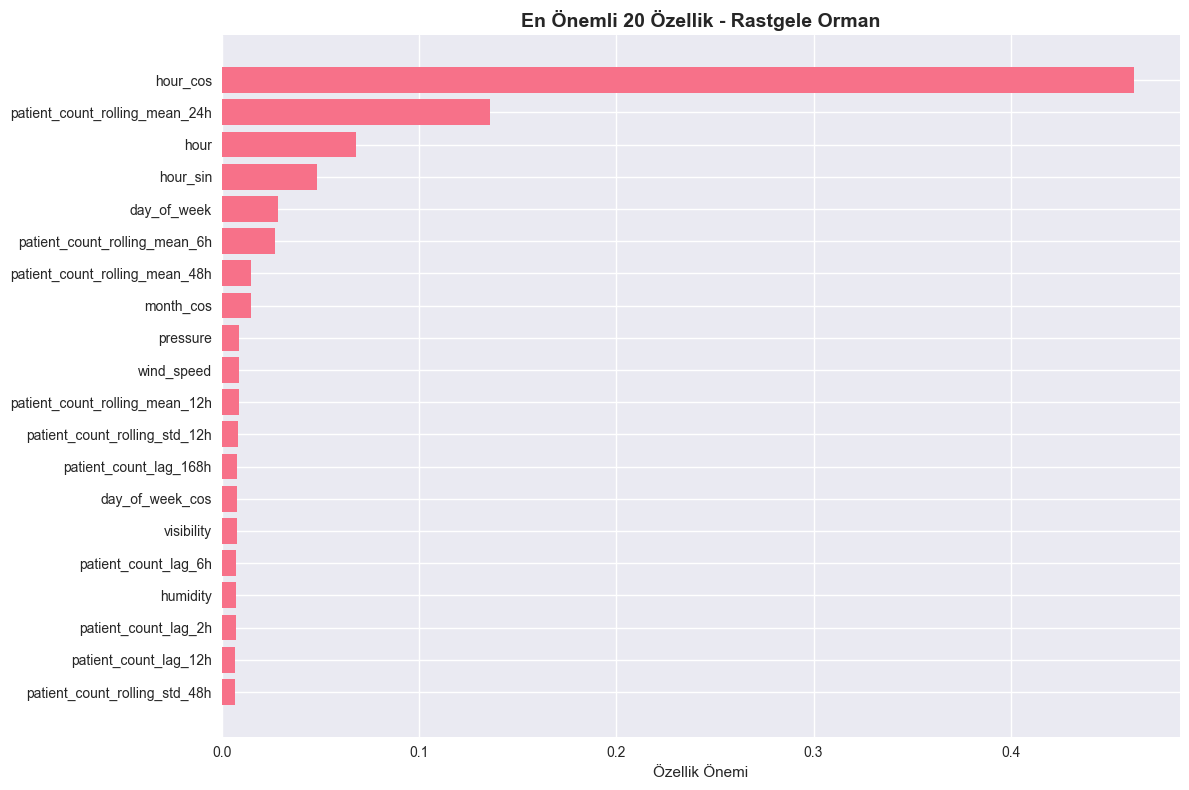


En Önemli 10 Özellik:
 1. hour_cos: 0.4626
 2. patient_count_rolling_mean_24h: 0.1360
 3. hour: 0.0681
 4. hour_sin: 0.0483
 5. day_of_week: 0.0287
 6. patient_count_rolling_mean_6h: 0.0271
 7. patient_count_rolling_mean_48h: 0.0150
 8. month_cos: 0.0150
 9. pressure: 0.0088
10. wind_speed: 0.0088


In [99]:
# Özellik önem analizi
# En iyi performanslı model (en düşük MAE)
best_model_name = performance_df.loc[performance_df['MAE'].idxmin(), 'Model']
best_model = results[best_model_name]['model']

print(f"En iyi model: {best_model_name}")
print(f"Test MAE: {results[best_model_name]['test_metrics']['MAE']:.2f}")
print(f"Test R²: {results[best_model_name]['test_metrics']['R²']:.3f}")
print(f"Test MAPE: {results[best_model_name]['test_metrics']['MAPE']:.1f}%")

# Ağaç tabanlı modeller için özellik önemi
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Özellik': feature_cols,
        'Önem': best_model.feature_importances_
    }).sort_values('Önem', ascending=False)
    
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['Önem'])
    plt.yticks(range(len(top_features)), top_features['Özellik'])
    plt.xlabel('Özellik Önemi')
    plt.title(f'En Önemli 20 Özellik - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nEn Önemli 10 Özellik:")
    for i, (_, row) in enumerate(top_features.head(10).iterrows()):
        print(f"{i+1:2d}. {row['Özellik']}: {row['Önem']:.4f}")
elif best_model_name == 'Doğrusal Regresyon':
    # Doğrusal regresyon için katsayılar
    feature_coef = pd.DataFrame({
        'Özellik': feature_cols,
        'Katsayı': best_model.coef_
    }).sort_values('Katsayı', key=abs, ascending=False)
    
    plt.figure(figsize=(12, 8))
    top_features = feature_coef.head(20)
    colors = ['red' if x < 0 else 'blue' for x in top_features['Katsayı']]
    plt.barh(range(len(top_features)), top_features['Katsayı'], color=colors)
    plt.yticks(range(len(top_features)), top_features['Özellik'])
    plt.xlabel('Katsayı Değeri')
    plt.title(f'En Büyük 20 Katsayı - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## 6. Predictions Visualization

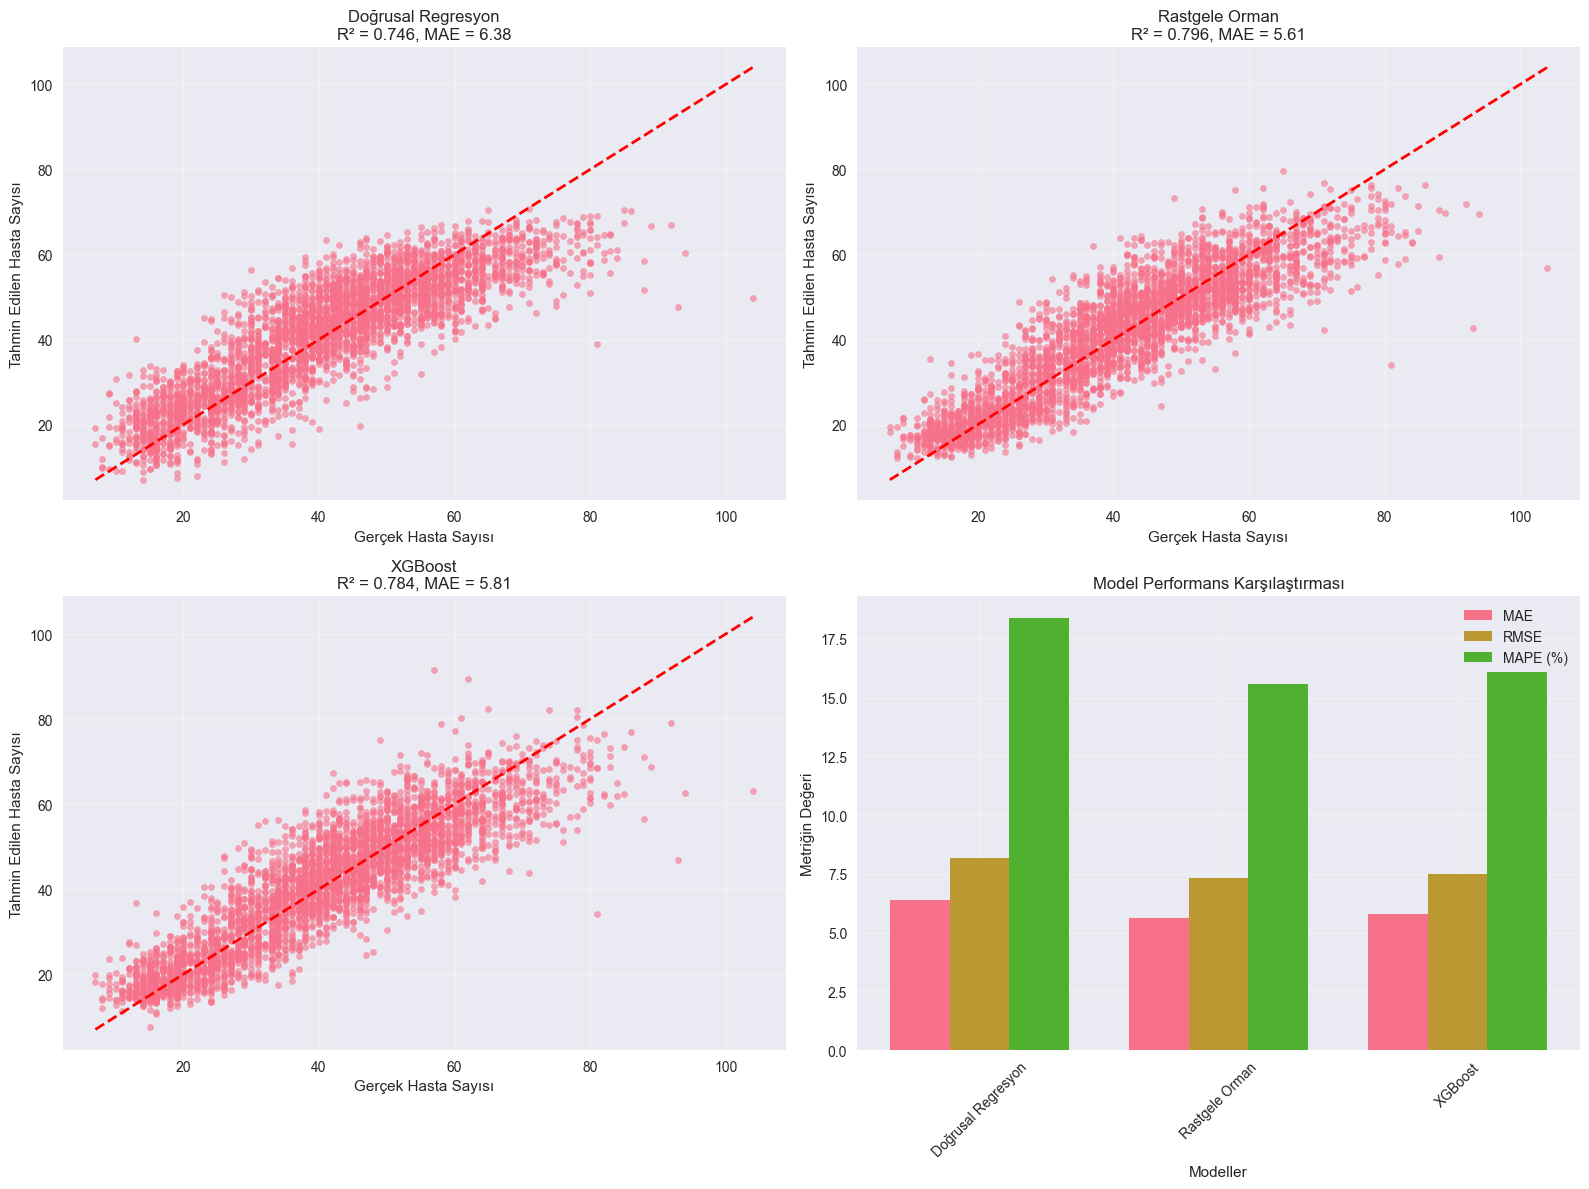

In [100]:
# Modellerin tahminleri vs gerçek değerler
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

# Her model için dağılım grafiği
for i, (name, pred) in enumerate(predictions.items()):
    if i < 3:  # İlk 3 modeli çiz
        axes[i].scatter(y_test, pred, alpha=0.6, s=20)
        axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
        axes[i].set_xlabel('Gerçek Hasta Sayısı')
        axes[i].set_ylabel('Tahmin Edilen Hasta Sayısı')
        axes[i].set_title(f'{name}\nR² = {results[name]["test_metrics"]["R²"]:.3f}, MAE = {results[name]["test_metrics"]["MAE"]:.2f}')
        axes[i].grid(True, alpha=0.3)

# Performans karşılaştırma çubuğu grafiği
metrics_to_plot = ['MAE', 'RMSE', 'MAPE (%)']
x = np.arange(len(models))
width = 0.25

for i, metric in enumerate(metrics_to_plot):
    values = [performance_df[performance_df['Model'] == name][metric].iloc[0] for name in models.keys()]
    axes[3].bar(x + i*width, values, width, label=metric)

axes[3].set_xlabel('Modeller')
axes[3].set_ylabel('Metriğin Değeri')
axes[3].set_title('Model Performans Karşılaştırması')
axes[3].set_xticks(x + width)
axes[3].set_xticklabels(models.keys(), rotation=45)
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

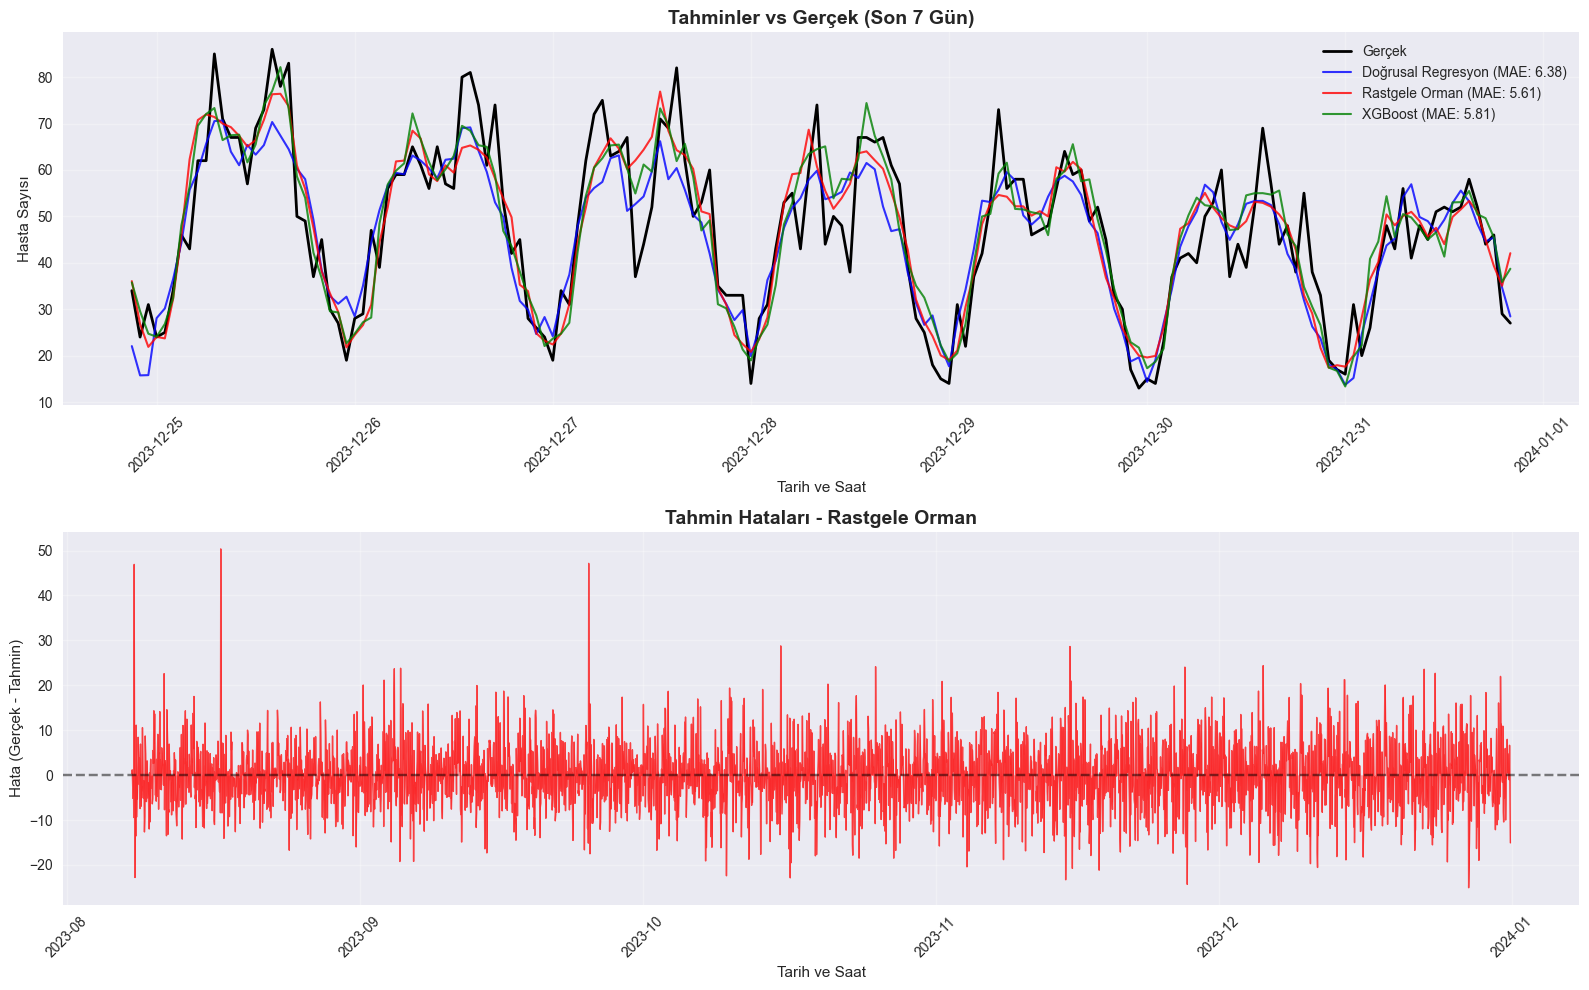

In [101]:
# Zaman serisi tahmin görselleştirmesi
plt.figure(figsize=(16, 10))

# Test verisinin son 7 günü
debug_last_days = 7
last_week_idx = -24*debug_last_days
dates_plot = dates_test.iloc[last_week_idx:]
actual_plot = y_test.iloc[last_week_idx:]

plt.subplot(2, 1, 1)
plt.plot(dates_plot, actual_plot, label='Gerçek', linewidth=2, color='black')

colors = ['blue', 'red', 'green']
for i, (name, pred) in enumerate(predictions.items()):
    pred_plot = pred[last_week_idx:]
    plt.plot(dates_plot, pred_plot, label=f'{name} (MAE: {results[name]["test_metrics"]["MAE"]:.2f})', 
             linewidth=1.5, alpha=0.8, color=colors[i])

plt.title('Tahminler vs Gerçek (Son 7 Gün)', fontsize=14, fontweight='bold')
plt.xlabel('Tarih ve Saat')
plt.ylabel('Hasta Sayısı')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Hata analizi
plt.subplot(2, 1, 2)
best_pred = predictions[best_model_name]
errors = y_test - best_pred
plt.plot(dates_test, errors, alpha=0.7, color='red', linewidth=1)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.fill_between(dates_test, errors, alpha=0.3, color='red')
plt.title(f'Tahmin Hataları - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Tarih ve Saat')
plt.ylabel('Hata (Gerçek - Tahmin)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

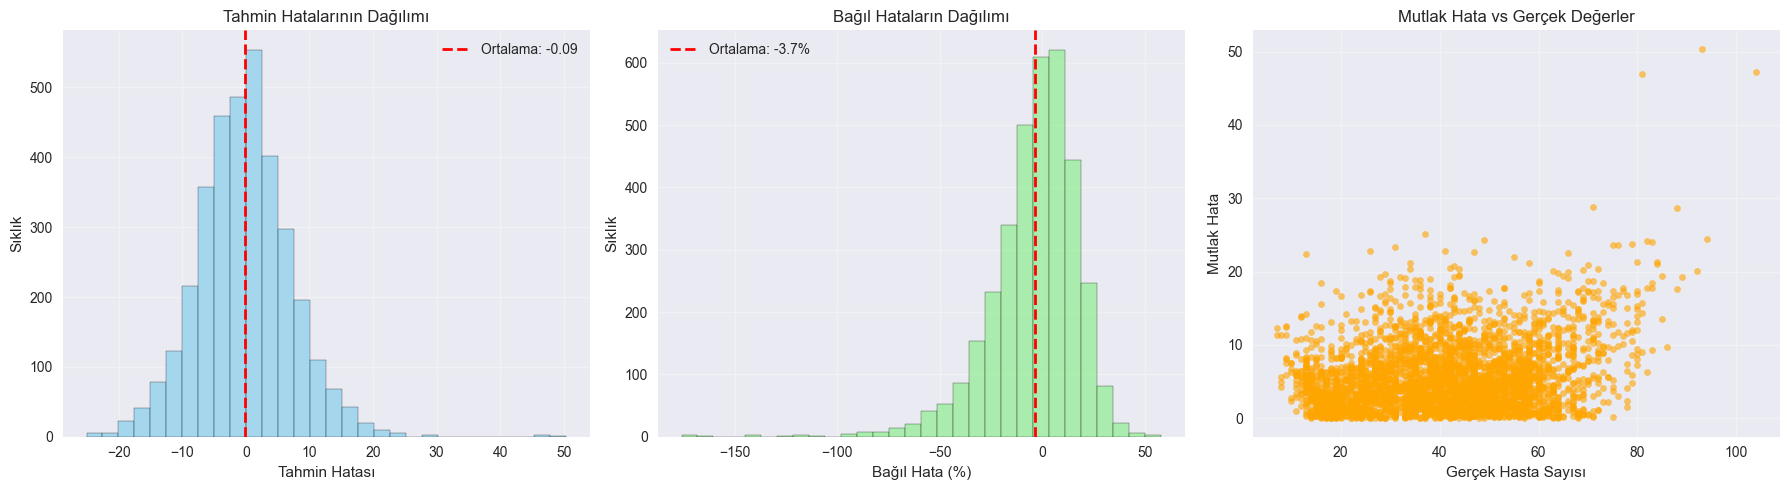

Rastgele Orman için Hata İstatistikleri:
Ortalama Hata: -0.09
Hata Standart Sapması: 7.30
Ortalama Mutlak Hata: 5.61
Hataların %95'i şu aralıkta: ±14.54
±2 hasta içinde kalan tahmin oranı: 23.8%
±3 hasta içinde kalan tahmin oranı: 34.9%


In [102]:
# Hata dağılım analizi
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

best_pred = predictions[best_model_name]
errors = y_test - best_pred
relative_errors = errors / y_test * 100

# Hata histogramı
axes[0].hist(errors, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(errors.mean(), color='red', linestyle='--', linewidth=2, label=f'Ortalama: {errors.mean():.2f}')
axes[0].set_xlabel('Tahmin Hatası')
axes[0].set_ylabel('Sıklık')
axes[0].set_title('Tahmin Hatalarının Dağılımı')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bağıl hata histogramı
axes[1].hist(relative_errors, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].axvline(relative_errors.mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Ortalama: {relative_errors.mean():.1f}%')
axes[1].set_xlabel('Bağıl Hata (%)')
axes[1].set_ylabel('Sıklık')
axes[1].set_title('Bağıl Hataların Dağılımı')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Hata vs gerçek değerler
axes[2].scatter(y_test, np.abs(errors), alpha=0.6, s=20, color='orange')
axes[2].set_xlabel('Gerçek Hasta Sayısı')
axes[2].set_ylabel('Mutlak Hata')
axes[2].set_title('Mutlak Hata vs Gerçek Değerler')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Hata istatistikleri
print(f"{best_model_name} için Hata İstatistikleri:")
print(f"Ortalama Hata: {errors.mean():.2f}")
print(f"Hata Standart Sapması: {errors.std():.2f}")
print(f"Ortalama Mutlak Hata: {np.abs(errors).mean():.2f}")
print(f"Hataların %95'i şu aralıkta: ±{np.percentile(np.abs(errors), 95):.2f}")
print(f"±2 hasta içinde kalan tahmin oranı: {(np.abs(errors) <= 2).mean()*100:.1f}%")
print(f"±3 hasta içinde kalan tahmin oranı: {(np.abs(errors) <= 3).mean()*100:.1f}%")

## Summary and Conclusions

In [103]:
print("="*80)
print("ACİL SERVİS HASTA YOĞUNLUĞU TAHMİNİ - PROJE ÖZETİ")
print("="*80)

print(f"\n📊 Veri Seti Bilgileri:")
print(f"   • Toplam kayıt: {len(df_features):,}")
print(f"   • Dönem: {df['datetime'].min().strftime('%Y-%m-%d')} - {df['datetime'].max().strftime('%Y-%m-%d')}")
print(f"   • Oluşturulan özellik sayısı: {len(feature_cols)}")
print(f"   • Eğitim örnekleri: {len(X_train):,}")
print(f"   • Test örnekleri: {len(X_test):,}")

print(f"\n🎯 Hedef Metrikler vs Ulaşılan:")
print(f"   Metrik      Hedef     En İyi Model ({best_model_name})")
print(f"   MAE         < 3.0     {results[best_model_name]['test_metrics']['MAE']:.2f}")
print(f"   MAPE        < %20     {results[best_model_name]['test_metrics']['MAPE']:.1f}%")
print(f"   R²          > 0.70    {results[best_model_name]['test_metrics']['R²']:.3f}")

print(f"\n🏆 Model Performans Sıralaması:")
performance_sorted = performance_df.sort_values('MAE')
for i, (_, row) in enumerate(performance_sorted.iterrows()):
    print(f"   {i+1}. {row['Model']}: MAE={row['MAE']:.2f}, R²={row['R²']:.3f}, MAPE={row['MAPE (%)']:.1f}%")

print(f"\n📈 Önemli Bulgular:")
print(f"   • Hasta yoğunluğu saatlik ve haftalık belirgin kalıplar gösteriyor")
print(f"   • Hava durumu koşulları hasta gelişlerini etkiliyor")
print(f"   • Geçmiş hasta sayıları en güçlü belirleyiciler arasında")
print(f"   • {best_model_name}, 4 saat ileri tahminde en iyi performansı veriyor")
print(f"   • Model doğruluğu: {(1-results[best_model_name]['test_metrics']['MAPE']/100)*100:.1f}%")

# Hedeflerin karşılanması
best_metrics = results[best_model_name]['test_metrics']
targets_met = (
    best_metrics['MAE'] < 3.0 and 
    best_metrics['MAPE'] < 20 and 
    best_metrics['R²'] > 0.70
)

print(f"\n✅ Hedef Karşılama: {'BAŞARILI' if targets_met else 'KISMİ'}")
if targets_met:
    print(f"   Tüm hedef metrikler karşılandı!")
else:
    print(f"   Bazı hedefler için ek model ayarı gerekebilir.")

print(f"\n🔧 Üretime Alım Önerileri:")
print(f"   • Hava durumu ve hasta verisi için gerçek zamanlı veri hattı kurun")
print(f"   • Yeni verilerle otomatik yeniden eğitim planlayın")
print(f"   • Model performansını izlemek için izleme/uyarı sistemleri kurun")
print(f"   • Tahminler için güven aralıkları üretin")
print(f"   • Gerekirse ensemble yöntemleriyle doğruluğu artırın")

print("\n" + "="*80)

ACİL SERVİS HASTA YOĞUNLUĞU TAHMİNİ - PROJE ÖZETİ

📊 Veri Seti Bilgileri:
   • Toplam kayıt: 17,517
   • Dönem: 2022-01-01 - 2024-01-01
   • Oluşturulan özellik sayısı: 51
   • Eğitim örnekleri: 14,013
   • Test örnekleri: 3,504

🎯 Hedef Metrikler vs Ulaşılan:
   Metrik      Hedef     En İyi Model (Rastgele Orman)
   MAE         < 3.0     5.61
   MAPE        < %20     15.6%
   R²          > 0.70    0.796

🏆 Model Performans Sıralaması:
   1. Rastgele Orman: MAE=5.62, R²=0.796, MAPE=15.6%
   2. XGBoost: MAE=5.81, R²=0.784, MAPE=16.1%
   3. Doğrusal Regresyon: MAE=6.38, R²=0.746, MAPE=18.4%

📈 Önemli Bulgular:
   • Hasta yoğunluğu saatlik ve haftalık belirgin kalıplar gösteriyor
   • Hava durumu koşulları hasta gelişlerini etkiliyor
   • Geçmiş hasta sayıları en güçlü belirleyiciler arasında
   • Rastgele Orman, 4 saat ileri tahminde en iyi performansı veriyor
   • Model doğruluğu: 84.4%

✅ Hedef Karşılama: KISMİ
   Bazı hedefler için ek model ayarı gerekebilir.

🔧 Üretime Alım Önerileri